In [14]:
import os
import re
import sys
import json
import math
import string
import zipfile
import collections
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, json

In [15]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

BASE_DIR = "/content/drive/MyDrive/ADV_DL"
TRAIN_FILE = "Corona_NLP_train.xls"   # CSV data with .xls suffix
TEST_FILE  = "Corona_NLP_test.xls"


Mounted at /content/drive


In [16]:
train_path = Path(BASE_DIR) / TRAIN_FILE
test_path  = Path(BASE_DIR) / TEST_FILE

assert train_path.exists(), f"Missing {train_path}"
assert test_path.exists(),  f"Missing {test_path}"

df_train = pd.read_csv(train_path, encoding="ISO-8859-1")
df_test  = pd.read_csv(test_path,  encoding="ISO-8859-1")

print("Train shape:", df_train.shape)
print("Test  shape:", df_test.shape)
df_train.head(3)


Train shape: (41157, 6)
Test  shape: (3798, 6)


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive


In [17]:
# # ---- Config ----
# USE_KAGGLE_API = False
# DATA_DIR = "."          # folder containing the CSVs (change if needed)
# TRAIN_FILE = "Corona_NLP_train.csv"
# TEST_FILE  = "Corona_NLP_test.csv"

# # ---- Kaggle (optional) ----
# if USE_KAGGLE_API:
#     try:
#         import kaggle
#     except ImportError:
#         !pip -q install kaggle
#         import kaggle

#             # dataset slug
#     DATASET = "datatattle/covid-19-nlp-text-classification"
#     os.makedirs("kaggle_download", exist_ok=True)
#     # This will create 'covid-19-nlp-text-classification.zip'
#     !kaggle datasets download -d {DATASET} -p kaggle_download
#     zip_path = Path("kaggle_download") / "covid-19-nlp-text-classification.zip"
#     if zip_path.exists():
#         with zipfile.ZipFile(zip_path, "r") as zf:
#             zf.extractall("kaggle_download")
#         DATA_DIR = "kaggle_download"

In [18]:
# # ---- Load ----
# train_path = Path(DATA_DIR) / TRAIN_FILE
# test_path  = Path(DATA_DIR) / TEST_FILE

# assert train_path.exists(), f"Missing {train_path}. Put CSVs in {DATA_DIR} or enable Kaggle API."
# assert test_path.exists(),  f"Missing {test_path}. Put CSVs in {DATA_DIR} or enable Kaggle API."

# df_train = pd.read_csv(train_path, encoding="ISO-8859-1")
# df_test  = pd.read_csv(test_path,  encoding="ISO-8859-1")

# print("Train shape:", df_train.shape)
# print("Test  shape:", df_test.shape)
# df_train.head(3)

In [19]:
df_train['Sentiment'].unique()

array(['Neutral', 'Positive', 'Extremely Negative', 'Negative',
       'Extremely Positive'], dtype=object)

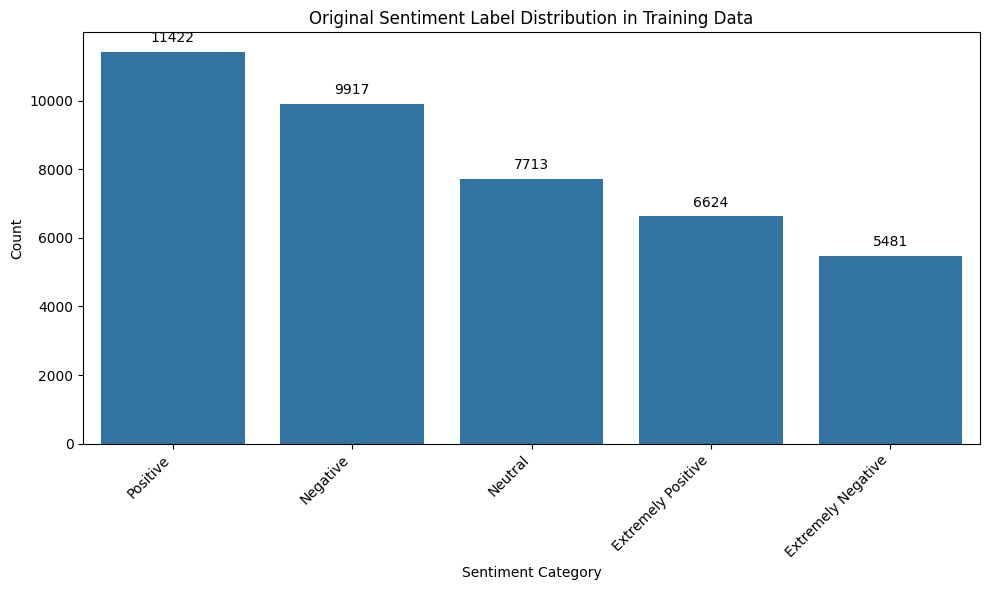

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_train is your training DataFrame loaded from the CSV file
# If your DataFrame is not named df_train, replace it with the correct name.
# For example, if you saved it as 'Corona_NLP_train.csv', you would load it like this:
# df_train = pd.read_csv('Corona_NLP_train.csv', encoding="ISO-8859-1")

# Create a figure and axis for the plot
plt.figure(figsize=(10, 6))

# Use seaborn to create a countplot of the 'Sentiment' column
ax = sns.countplot(data=df_train, x='Sentiment', order=df_train['Sentiment'].value_counts().index)

# Add title and labels for clarity
plt.title('Original Sentiment Label Distribution in Training Data')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability

# Annotate each bar with its count
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10),
                textcoords='offset points')

# Display the plot
plt.tight_layout()
plt.show()

### Standardizing Sentiment Labels

The original dataset contains **five sentiment categories**:
- Extremely Negative
- Negative
- Neutral
- Positive
- Extremely Positive

#### Objective
We map these into **three broader labels** — `negative`, `neutral`, and `positive` — to:
- Increase the number of samples per class and reduce class imbalance.
- Simplify the classification task and improve model stability.
- Reduce subjectivity between “positive” vs “extremely positive” and similar pairs.

#### What the code does
- Prints dataset information and original sentiment distribution.
- Defines a mapping (`label_map`) to merge extreme and normal polarities. The label map has marked our labels this way: "Extremely Negative": -1,"Negative": -1,"Neutral": 0,"Positive": 1,  "Extremely Positive": 1.
  Ultimately - marking Negative as -1, Neutral marked as 0, and Positive marked as 1.
- Creates a new column `sentiment_std` in both train and test datasets containing the standardized 3-class labels.
- Prints the new class distribution for validation.




--- Verifying Standardized Sentiment Labels ---
Information about df_train after adding 'sentiment_std':
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
 6   sentiment_std  41157 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 2.2+ MB


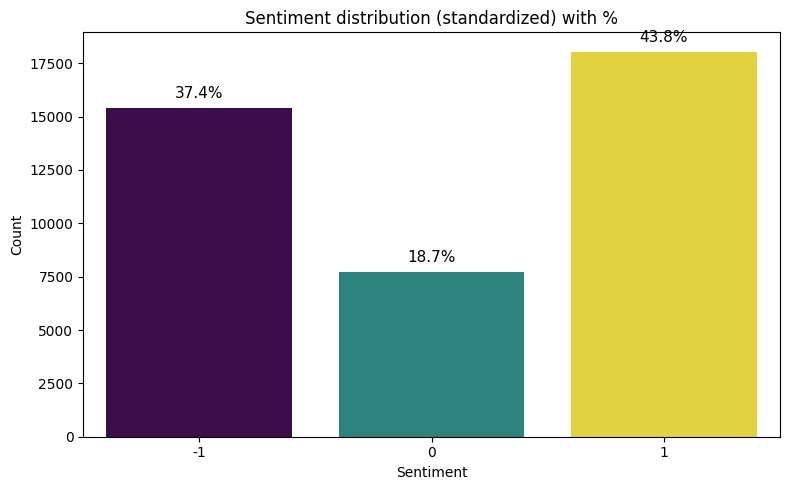

In [21]:
# --- Standardizing Sentiment Labels (Moved to an earlier position) ---
# This block defines the mapping for sentiment labels and creates the 'sentiment_std' column
# It needs to be executed before any analysis or filtering that uses 'sentiment_std'.

# Define a mapping to merge extreme and normal polarities into a 3-class system [3]
label_map = {
    "Extremely Negative": -1,
    "Negative": -1,
    "Neutral": 0,
    "Positive": 1,
    "Extremely Positive": 1
}

# Create the new 'sentiment_std' column in both train and test datasets [3]
# Apply the mapping to the 'Sentiment' column
df_train["sentiment_std"] = df_train["Sentiment"].map(label_map)
df_test["sentiment_std"] = df_test["Sentiment"].map(label_map) # Apply to df_test as well for consistency

# --- Optional: Verify the new class distribution for validation (as described in [3], [4]) ---
# You might need to ensure 'matplotlib.pyplot' and 'seaborn' are imported at the top of your notebook if not already.
# They are typically imported in the initial imports block [5, 6].
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Verifying Standardized Sentiment Labels ---")
print("Information about df_train after adding 'sentiment_std':")
df_train.info() # [7]

# Verify class balance in 'sentiment_std' [4]
plt.figure(figsize=(8, 5))
# Note: Passing `palette` without assigning `hue` is deprecated, so 'x' is explicitly assigned to 'hue' [4]
ax = sns.countplot(data=df_train, x="sentiment_std", hue="sentiment_std", palette="viridis", legend=False)
total = len(df_train)
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f"{100*height/total:.1f}%",
                (p.get_x() + p.get_width()/2., height),
                ha="center", va="bottom", fontsize=11, xytext=(0, 5),
                textcoords="offset points")

ax.set_title("Sentiment distribution (standardized) with %")
ax.set_xlabel("Sentiment")
ax.set_ylabel("Count")
plt.tight_layout()
plt.show()



### Sentiment Class Distribution – Imbalance Observed

From the label distribution plot, we can see that the dataset is **imbalanced**:

#### Why this matters
In classification tasks, class imbalance can cause the model to:
- **Bias predictions** toward the majority class (higher accuracy but poor performance on minority classes).
- **Under-learn minority classes**, leading to low recall/precision for those labels.
- Provide misleading evaluation metrics if the imbalance is not addressed.

#### Plan
Since Part A focuses on **EDA and text preprocessing**, we will keep the dataset as-is for now to maintain the original distribution for analysis.  
We will address the imbalance in **Part B** during model training, using techniques such as: **Class weighting** in the loss function.

Balancing the data in Part B will help the trained models learn **more equally from all classes**, improving their ability to classify **neutral** tweets as well as positive and negative ones.




# Data Cleaning

### Missing Values Check
Before running EDA, we first check for missing values in the dataset.
This helps identify incomplete records that might need to be dropped or imputed.
For sentiment analysis, tweets with missing text or labels are unusable and should be removed.


In [22]:
# Count missing values and percentage per column
missing_counts = df_train.isnull().sum()
missing_percent = (missing_counts / len(df_train)) * 100
missing_df = pd.DataFrame({
    "missing_count": missing_counts,
    "missing_percent": missing_percent
}).sort_values(by="missing_count", ascending=False)

display(missing_df)


,missing_count,missing_percent
Location,8590,20.871298
UserName,0,0.000000
ScreenName,0,0.000000
TweetAt,0,0.000000
OriginalTweet,0,0.000000
Sentiment,0,0.000000
sentiment_std,0,0.000000


### Missing Values Handling

As shown in the previous output, we found missing values only in the Location column (~21% of the training data). The OriginalTweet and Sentiment columns, which are essential for our task, have no missing values.

Since location data is not used for this sentiment classification project, we will now remove the Location column from both the training and testing datasets. This simplifies our data and ensures our models focus on the most relevant features for the task.


In [23]:
# Drop the Location column from both train and test dataframes
df_train = df_train.drop(columns=['Location'])
df_test = df_test.drop(columns=['Location'])

### Duplicate Tweet Check

Duplicate tweets can over-represent certain opinions and bias the model.  
Here, we check for duplicates in `OriginalTweet` to ensure data integrity before modeling.  
If duplicates were found, we would decide based on their potential impact whether to remove these records.


In [24]:
duplicate_count = df_train.duplicated(subset=["OriginalTweet"]).sum()
print(f"Number of duplicate tweets: {duplicate_count}")


Number of duplicate tweets: 0


Nothing to remove

### Distribution of Tweet Lengths (Characters) with Key Statistics

We will visualize the distribution of tweet lengths in characters, and mark:
- **Mean**: red dashed line
- **Median**: green dashed line
- **Q1 (25th percentile)** and **Q3 (75th percentile)**: orange dashed lines

This allows us to see:
- The overall spread and shape of the distribution.
- Where most tweets lie compared to the mean and median.
- Whether there is a long tail of very long tweets.


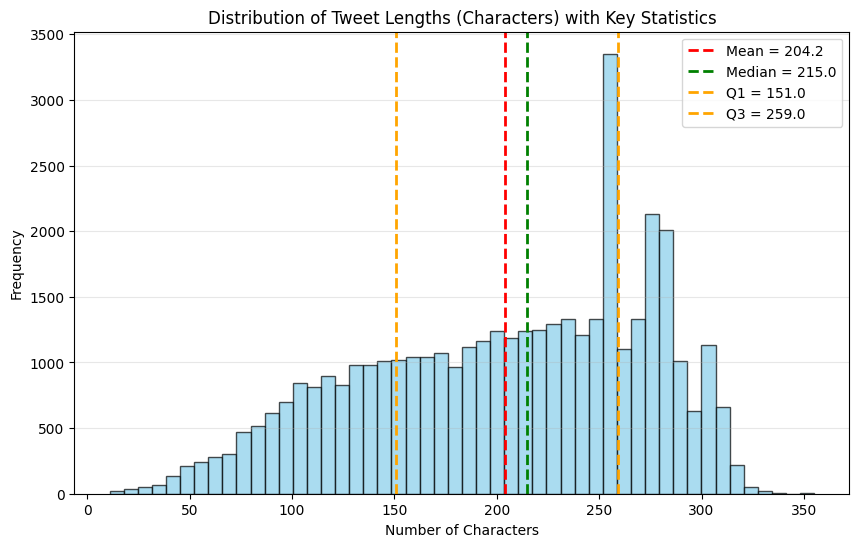

In [25]:
# Create length columns
df_train["len_chars"] = df_train["OriginalTweet"].apply(len)
df_train["len_words"] = df_train["OriginalTweet"].apply(lambda x: len(x.split()))

# Choose which length to analyze — here using len_chars
lengths = df_train["len_chars"]

# Compute stats
mean_val = lengths.mean()
median_val = lengths.median()
q1 = lengths.quantile(0.25)
q3 = lengths.quantile(0.75)

# Plot histogram
plt.figure(figsize=(10,6))
plt.hist(lengths, bins=50, color="skyblue", edgecolor="black", alpha=0.7)

# Add statistical lines
plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f"Mean = {mean_val:.1f}")
plt.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f"Median = {median_val:.1f}")
plt.axvline(q1, color='orange', linestyle='--', linewidth=2, label=f"Q1 = {q1:.1f}")
plt.axvline(q3, color='orange', linestyle='--', linewidth=2, label=f"Q3 = {q3:.1f}")

# Labels and legend
plt.title("Distribution of Tweet Lengths (Characters) with Key Statistics")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()


# Analysis of Tweet Lengths

The histogram of tweet character lengths is crucial for understanding our text data's distribution and informing our preprocessing choices.  
It shows that the majority of tweets are concentrated between **151 and 259 characters**, but this raw count doesn't account for how transformer models handle text.  
These models operate on **subword tokens**, not raw characters.

---

## Action Plan for Next Steps

1. **Analyze Model-Specific Token Lengths**  
   We will use the tokenizers for **DistilBERT** and **BERTweet** to calculate the true token count for each tweet.

2. **Determine an Optimal `max_seq_length`**  
   Using the token length distributions (e.g., the 99th percentile), we will choose a `max_seq_length` that balances data retention with computational efficiency for our models.

3. **Explore Other Text Properties**  
   We will also use a **2D heatmap** to analyze the relationship between word and character counts.  
   This can reveal outliers such as:
   - Gibberish  
   - Heavily truncated text  
   
   that might not be captured by a simple length analysis.


### 2D Heatmap: Words vs. Characters (Frequency)

We plot a 2D histogram where:
- **X‑axis** = number of words per tweet (`len_words`)
- **Y‑axis** = number of characters per tweet (`len_chars`)
- **Color** = frequency of tweets in each bin

This reveals common tweet “shapes” and potential outliers (e.g., very few words but many characters).
We also support an optional **log color scale** to make sparse regions visible.


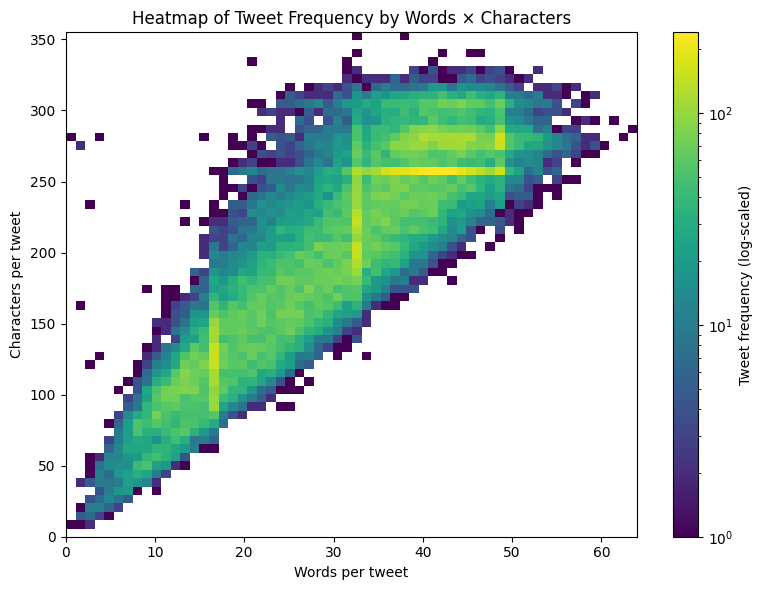

Total tweets: 41157
Words — min:1  median:32.0  mean:30.50  max:64
Chars — min:11  median:215.0  mean:204.20  max:355


In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Pull arrays
w = df_train["len_words"].to_numpy()
c = df_train["len_chars"].to_numpy()

# Choose binning (tweak if needed)
# Roughly: words up to 60, chars up to 350; use data-driven caps
w_max = max(int(np.percentile(w, 99)), w.max())
c_max = max(int(np.percentile(c, 99)), c.max())

# Number of bins (increase for finer resolution)
xbins = 60
ybins = 60

# Make 2D histogram
H, xedges, yedges = np.histogram2d(w, c, bins=[xbins, ybins],
                                   range=[[0, w_max], [0, c_max]])

# Plot (log color helps if counts vary a lot)
plt.figure(figsize=(8,6))
plt.imshow(
    H.T,
    origin="lower",
    aspect="auto",
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    norm=LogNorm(vmin=max(H[H>0].min() if H.sum() else 1, 1), vmax=H.max() if H.max()>0 else 1),
)
plt.colorbar(label="Tweet frequency (log-scaled)")
plt.xlabel("Words per tweet")
plt.ylabel("Characters per tweet")
plt.title("Heatmap of Tweet Frequency by Words × Characters")
plt.tight_layout()
plt.show()

# Optional quick prints
print(f"Total tweets: {len(w)}")
print(f"Words — min:{w.min()}  median:{np.median(w):.1f}  mean:{w.mean():.2f}  max:{w.max()}")
print(f"Chars — min:{c.min()}  median:{np.median(c):.1f}  mean:{c.mean():.2f}  max:{c.max()}")


### Inspecting Top-Left Region of Words × Characters Space

We select tweets with:
- **Few words** (e.g., ≤ 5 words)
- **Many characters** (e.g., ≥ 150 characters)

These are suspicious because they contain long tokens (often noise, giant hashtags, or URLs) but little actual content.  
We display them for manual review before deciding on removal.


In [27]:
# Thresholds — tweak as needed
max_words = 5
min_chars = 150

# Mask for top-left region
top_left_mask = (df_train["len_words"] <= max_words) & (df_train["len_chars"] >= min_chars)

# Extract examples
top_left_tweets = df_train.loc[top_left_mask, ["OriginalTweet", "sentiment_std", "len_words", "len_chars"]]

print(f"Number of tweets in top-left region: {top_left_tweets.shape[0]}")
display(top_left_tweets)



Number of tweets in top-left region: 6


,OriginalTweet,sentiment_std,len_words,len_chars
7259,Coronavirus...Better...Netizens...Mockery...Mo...,1,2,274
7260,US...Impose...New...Iran...Link...Sanctions......,1,2,274
10732,Perfect...Storm...Coronavirus...Pose...Big...T...,-1,4,280
18063,Germany...Merkel...Quarantine...supermarket......,-1,3,235
27610,Brazil...Health...Official...Confirm...First.....,1,1,279
34718,Keda-ceramics-Ghana-and-Sunda-International-de...,0,2,164


The previous analysis of the "Top-Left Region of Words × Characters Space" successfully identified a data quality issue: tweets containing very long tokens with minimal words, as shown in the examples below:
OriginalTweetsentiment_stdlen_wordslen_chars7259Coronavirus...Better...Netizens...Mockery...Mo...122747260US...Impose...New...Iran...Link...Sanctions......1227410732Perfect...Storm...Coronavirus...Pose...Big...T...-1428018063Germany...Merkel...Quarantine...supermarket......-1323527610Brazil...Health...Official...Confirm...First.....1127934718Keda-ceramics-Ghana-and-Sunda-International-de...02164




In [28]:
# Function to normalize punctuation that concatenates words
def normalize_concatenated_words(text):
    # Replace sequences of two or more dots with a single space
    return re.sub(r'\.{2,}', ' ', str(text))

# Apply this function to the 'covid_norm' column for both dataframes
df_train['OriginalTweet'] = df_train['OriginalTweet'].apply(normalize_concatenated_words)
df_test['OriginalTweet'] = df_test['OriginalTweet'].apply(normalize_concatenated_words)

# Display a few examples to confirm the change
print("Example of cleaned text:")
for s in df_train['OriginalTweet'].head(2).tolist():
    print(s)

Example of cleaned text:
@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8
advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order


### Words-to-Characters Ratio Analysis

We compute the ratio:
\[
\text{ratio} = \frac{\text{number of words}}{\text{number of characters}}
\]

- **Low ratio** → few words with long tokens (possible junk/URL-heavy tweets).
- **High ratio** → many very short words (possible repetitive or low-content tweets).

We plot the distribution and inspect extreme values for potential removal.


count    41157.000000
mean         0.149370
std          0.028187
min          0.003584
1%           0.085216
5%           0.101961
50%          0.150000
95%          0.194030
99%          0.211538
max          0.315789
Name: word_char_ratio, dtype: float64


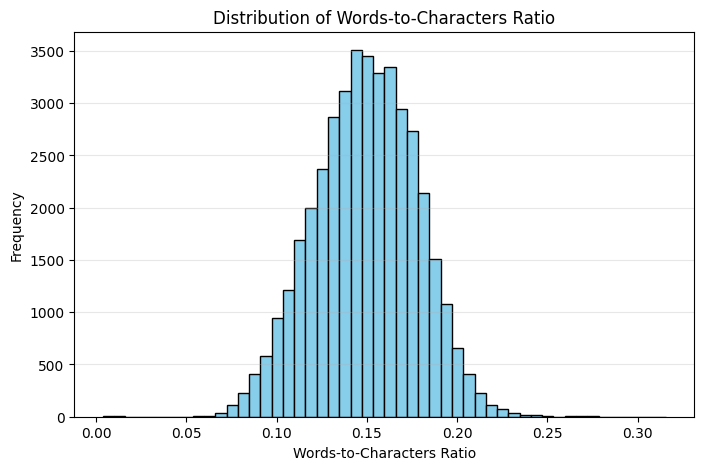

In [29]:
# Avoid division by zero
df_train["word_char_ratio"] = df_train.apply(
    lambda row: row["len_words"] / row["len_chars"] if row["len_chars"] > 0 else 0,
    axis=1
)

# Basic statistics
print(df_train["word_char_ratio"].describe(percentiles=[0.01, 0.05, 0.95, 0.99]))

# Histogram
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(df_train["word_char_ratio"], bins=50, color="skyblue", edgecolor="black")
plt.xlabel("Words-to-Characters Ratio")
plt.ylabel("Frequency")
plt.title("Distribution of Words-to-Characters Ratio")
plt.grid(axis="y", alpha=0.3)
plt.show()


In [30]:
# Low ratio suspects (few words but many characters)
low_threshold = df_train["word_char_ratio"].quantile(0.01)  # bottom 1%
low_ratio_tweets = df_train[df_train["word_char_ratio"] <= low_threshold]
print("="*20, " LOW RATIO TWEETS (few words, many characters) ", "="*20)
print(f"Low ratio threshold (1% quantile): {low_threshold:.4f} → {low_ratio_tweets.shape[0]} tweets")
print(f"Lowest ratio in dataset: {df_train['word_char_ratio'].min():.4f}")
display(low_ratio_tweets[["OriginalTweet", "sentiment_std", "len_words", "len_chars", "word_char_ratio"]].head(20))

# High ratio suspects (many short words)
high_threshold = df_train["word_char_ratio"].quantile(0.99)  # top 1%
high_ratio_tweets = df_train[df_train["word_char_ratio"] >= high_threshold]
print("\n", "="*20, " HIGH RATIO TWEETS (many short words) ", "="*20)
print(f"High ratio threshold (99% quantile): {high_threshold:.4f} → {high_ratio_tweets.shape[0]} tweets")
print(f"Highest ratio in dataset: {df_train['word_char_ratio'].max():.4f}")
display(high_ratio_tweets[["OriginalTweet", "sentiment_std", "len_words", "len_chars", "word_char_ratio"]].head(20))


====================  LOW RATIO TWEETS (few words, many characters)  ====================
Low ratio threshold (1% quantile): 0.0852 → 412 tweets
Lowest ratio in dataset: 0.0036


,OriginalTweet,sentiment_std,len_words,len_chars,word_char_ratio
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,0,8,111,0.072072
72,Corona scare sends sea-food prices skyrocketin...,0,22,297,0.074074
186,@olson_jessie @NashTerrance @MccrorieJim @Army...,0,19,255,0.074510
477,Links with info on communicating with children...,-1,21,257,0.081712
549,Happening across the country right now #coron...,0,11,132,0.083333
888,Online grocery shopping first trial #coronavir...,0,14,171,0.081871
1128,"For more updates, visit https://t.co/i2ZTA1igt...",0,6,71,0.084507
1253,@hollywoodmerkin @dansewell Online shopping #c...,0,6,82,0.073171
1674,Our local grocery store @RealCdnSS in @Norfolk...,0,15,187,0.080214
2028,COVID-19 Supermarket Sweep https://t.co/VzQIji...,0,4,50,0.080000



 ====================  HIGH RATIO TWEETS (many short words)  ====================
High ratio threshold (99% quantile): 0.2115 → 422 tweets
Highest ratio in dataset: 0.3158


,OriginalTweet,sentiment_std,len_words,len_chars,word_char_ratio
85,I work in retail I keep stock back for our old...,1,59,275,0.214545
271,Got to the grocery store amp had to call my wi...,1,19,84,0.226190
768,My mum called me and told me I might want to s...,0,24,106,0.226415
787,People buy crazy stuff 4 in a,-1,7,29,0.241379
826,My wife got to grocery on Union St in Bangor a...,0,43,202,0.212871
914,I went to vote and they sprayed me with Lysol ...,0,26,120,0.216667
1004,warning at 32c this morning in Please don t pa...,1,23,104,0.221154
1157,Don t forget to stock up your pet food,-1,9,38,0.236842
1490,Went to the grocery store and the guy in front...,1,60,274,0.218978
1501,It s not just during that we need each other W...,-1,53,250,0.212000


### Words-to-Characters Ratio Analysis – Findings

We examined the **words-to-characters ratio** for all tweets to identify potential outliers:
- **Low ratio** was expected to capture tweets with very few words but extremely long tokens (e.g., giant URLs, concatenated hashtags, gibberish).
- **High ratio** was expected to capture tweets with many very short words, potentially repetitive or low-information.

#### Observation
After inspecting tweets at both extremes (bottom 1% and top 1% of the ratio distribution), we did **not** find a clear, consistent pattern that would justify automated removal:
- Many low-ratio tweets are valid sentences containing longer words or multiple hashtags, not necessarily noise.
- High-ratio tweets often contain legitimate short words and still carry sentiment.
- No obvious “hard threshold” emerged that would reliably separate irrelevant tweets from useful ones.

#### Conclusion & Next Steps
The words-to-characters ratio **alone** does not provide a reliable signal for outlier removal in this dataset.  
As a result, we will **explore additional, more targeted methods** that are better suited for detecting noise in tweet data, such as:
- Detecting **very long individual tokens** that are not URLs or hashtags (possible gibberish).
- Identifying **tweets with extremely low semantic content** (e.g., only emojis or stopwords).
- Optionally combining heuristic rules with lightweight classification signals (e.g., language detection, spam keywords) for a hybrid approach.

The focus will remain on **interpretable, explainable filtering** so that any removal decisions can be justified in the project report.


In [31]:
def preview_long_token_thresholds(df, text_col="OriginalTweet", cutoffs=(16,18,20,22,24), topn=5):
    import re, string
    def is_url(tok):  return tok.startswith("http") or tok.startswith("www.")
    def is_mention(tok): return tok.startswith("@") and len(tok)>1
    def is_hashtag(tok): return tok.startswith("#") and len(tok)>1
    def long_tokens(s, min_len):
        toks = s.split()
        out = []
        for t in toks:
            if is_url(t) or is_mention(t) or is_hashtag(t):
                continue
            core = t.strip(string.punctuation)
            if len(core) >= min_len:
                out.append(core)
        return out

    for L in cutoffs:
        mask = df[text_col].astype(str).apply(lambda s: len(long_tokens(s, L))>0)
        print(f"Length ≥{L}: {mask.sum()} tweets flagged")
        display(df.loc[mask, [text_col,"len_words","len_chars"]].head(topn))

# use it:
preview_long_token_thresholds(df_train, cutoffs=(16,18,20,22,24), topn=3)


Length ≥16: 1463 tweets flagged


,OriginalTweet,len_words,len_chars
38,my wife works retail&amp;a customer came in ye...,43,288
134,Good move in tackling down the Covid-19 spread...,38,258
196,&gt;@MassGovernor announces $10M loan fund adm...,35,320


Length ≥18: 869 tweets flagged


,OriginalTweet,len_words,len_chars
38,my wife works retail&amp;a customer came in ye...,43,288
134,Good move in tackling down the Covid-19 spread...,38,258
209,How about free delivery and no service fee for...,27,208


Length ≥20: 520 tweets flagged


,OriginalTweet,len_words,len_chars
38,my wife works retail&amp;a customer came in ye...,43,288
209,How about free delivery and no service fee for...,27,208
485,Amazon delivery infrastructure strained as COV...,15,146


Length ≥22: 384 tweets flagged


,OriginalTweet,len_words,len_chars
38,my wife works retail&amp;a customer came in ye...,43,288
209,How about free delivery and no service fee for...,27,208
548,On behalf of all my peers in the supermarket i...,36,251


Length ≥24: 198 tweets flagged


,OriginalTweet,len_words,len_chars
209,How about free delivery and no service fee for...,27,208
606,smart and pragmatic from @Telstra @andy_penn g...,27,226
612,Coronavirus Live Updates: France Struggling to...,24,214


### Very-Long-Token Preview — Findings

We tested an interpretable heuristic to flag tweets that contain **at least one very long word** (excluding URLs, hashtags, and mentions), using several candidate thresholds (≥16, ≥18, ≥20, ≥22, ≥24 characters). The goal was to surface obvious gibberish/keyboard mashes for potential removal.

**Result:** The previewed samples at all thresholds looked **legitimate** (e.g., normal sentences with occasional long tokens or punctuation), and did **not** reveal a consistent pattern of noise. Therefore, this heuristic **did not provide a clear removal criterion** for our dataset at this stage.

**Decision:** We **did not apply** this rule for automatic deletion in Part A.


## Too Longh Tweewts → Too Short Ones :)
### Tweets Containing Exactly Two Words

We identify tweets where, after trimming whitespace, the text contains **one or two words**.  
This helps us spot:
- Short tweets that may lack sentiment context.
- Cases where the meaning depends heavily on context (e.g., “Hate this”).
We only display them for manual review at this stage.


In [32]:
# Mask for exactly two words (ignores extra spaces)
two_word_mask = df_train['OriginalTweet'].astype(str).str.strip().apply(lambda x: len(x.split()) <= 2)

# Extract examples
two_word_tweets = df_train.loc[two_word_mask, ["OriginalTweet", "sentiment_std", "len_words", "len_chars"]]

print(f"Number of two-word tweets: {two_word_tweets.shape[0]}")
two_word_tweets.head(20)  # show first 20 for inspection


Number of two-word tweets: 11


,OriginalTweet,sentiment_std,len_words,len_chars
15577,Tissue Issue,0,2,12
16872,Cartoon for,0,2,11
18977,Survival strategy,0,2,19
19410,BREAKING NEWS,0,2,13
23975,Unbelievable https://t.co/fBrPYaxNH6,1,2,36
32448,Quarantine life,0,2,17
33693,https://t.co/ekWLAAfheP\r\r\nHeartbreaking.,-1,2,40
34718,Keda-ceramics-Ghana-and-Sunda-International-de...,0,2,164
35526,amp,0,1,11
37996,Crisis averted,-1,2,14


Our code specifically flags tweets with one or two words. The output shows examples like "Tissue Issue" and "Quarantine life". While concise, these tweets may still carry a clear sentiment.

Based on this finding, we've concluded that removing these short tweets is not a necessary or beneficial preprocessing step. Modern transformer models like DistilBERT and BERTweet are robust enough to extract meaningful sentiment from short sequences. Given the class imbalance in our dataset, retaining all available data is a priority to ensure the model learns from a diverse range of examples. Therefore, we will keep these tweets in our dataset and not apply any filtering based on a low word count.



# EDA

In [33]:
# Basic text quality checks
# --------------------------
text_col = "OriginalTweet"

def has_url(s):
    return bool(re.search(r"http[s]?://|www\.", s))

def count_hashtags(s):
    return s.count("#")

def count_mentions(s):
    return s.count("@")

def count_emojis(s):
    # very rough heuristic: count non-ascii characters commonly used as emojis
    return sum(1 for ch in s if ord(ch) > 10000)

def count_punct(s):
    return sum(ch in string.punctuation for ch in s)

def length_chars(s):
    return len(s)

def length_words(s):
    return len(s.split())

for col in [text_col]:
    assert col in df_train.columns, f"Column '{col}' not found!"

meta_feats = {}
meta_feats["has_url"]      = df_train[text_col].astype(str).map(has_url)
meta_feats["n_hashtags"]   = df_train[text_col].astype(str).map(count_hashtags)
meta_feats["n_mentions"]   = df_train[text_col].astype(str).map(count_mentions)
meta_feats["n_emojis"]     = df_train[text_col].astype(str).map(count_emojis)
meta_feats["n_punct"]      = df_train[text_col].astype(str).map(count_punct)
meta_feats["len_chars"]    = df_train[text_col].astype(str).map(length_chars)
meta_feats["len_words"]    = df_train[text_col].astype(str).map(length_words)

for k, v in meta_feats.items():
    df_train[k] = v

df_train[["sentiment_std","has_url","n_hashtags","n_mentions","n_emojis","n_punct","len_chars","len_words"]].head(5)


,sentiment_std,has_url,n_hashtags,n_mentions,n_emojis,n_punct,len_chars,len_words
0,0,True,0,3,0,19,111,8
1,1,False,0,0,0,0,237,38
2,1,True,0,0,0,8,131,14
3,1,True,7,0,0,19,304,42
4,-1,True,6,0,0,20,308,40


### Most Frequent Terms per Sentiment (Count-Based)

In this step, we use **CountVectorizer** to identify the most frequent unigrams (single words) in tweets for each sentiment class: **negative**, **neutral**, and **positive**.

**Why we did it:**
- High-frequency words give us a quick overview of the vocabulary most associated with each sentiment.
- This helps spot domain-specific patterns (e.g., hashtags, slang, COVID-related terms) that may influence model performance.
- It also guides **preprocessing decisions** — for example, if certain hashtags or word variants dominate across all classes, we may normalize or remove them.
- We use a custom `token_pattern` so hashtags (`#StayHome`) and mentions (`@user`) are preserved as tokens.

**Things to note:**
- We fit a global vectorizer to ensure `min_df` (minimum document frequency) is calculated across the entire training set.
- Stopwords are removed so we focus on meaningful tokens.


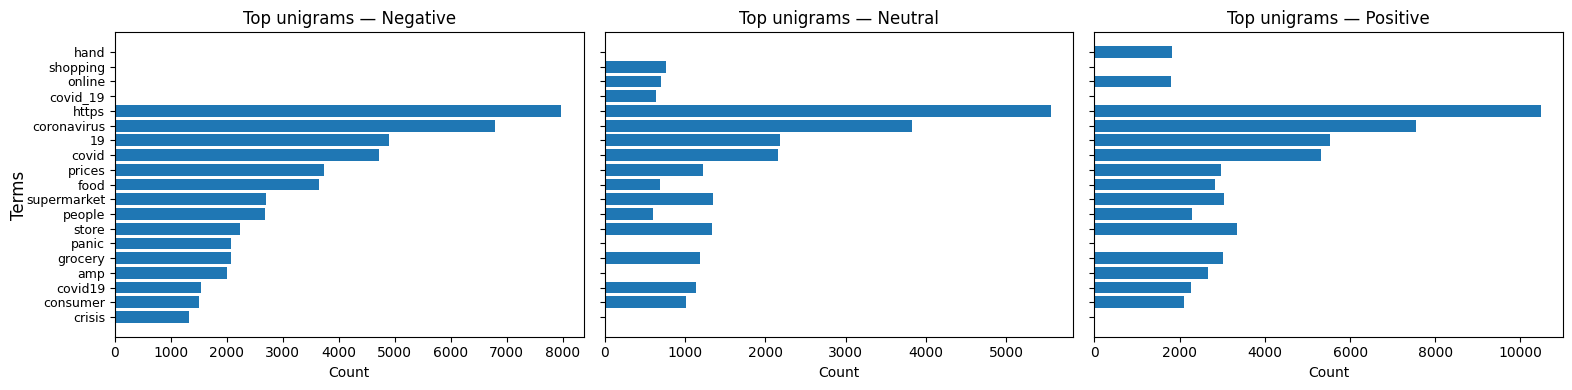

In [34]:
# keep your existing imports
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- label maps (put this near your imports) ----
_str2int = {
    "negative": -1, "neg": -1, "-1": -1,
    "neutral":  0,  "neu": 0,  "neut": 0, "0": 0,
    "positive":  1, "pos": 1,  "1": 1,
}
_int2str = {-1: "Negative", 0: "Neutral", 1: "Positive"}


def _standardize_sentiments(series):
    """Return a Series where string labels are mapped to -1/0/1, and ints are kept."""
    mapped = series.map(_str2int)
    return mapped.where(mapped.notna(), series)

def _standardize_label(label):
    """Map label to -1/0/1 if passed as string; otherwise return as-is."""
    if isinstance(label, str):
        return _str2int.get(label, label)
    return label

def top_terms(df, label, text_col="OriginalTweet", n=15,
              stopwords="english", base_min_df=5, ngram_range=(1,1)):
    # harmonize sentiment labels
    sent_std = _standardize_sentiments(df["sentiment_std"])
    lab_std = _standardize_label(label)

    # subset & clean
    sub = df.loc[sent_std == lab_std, text_col].dropna().astype(str)
    sub = sub[sub.str.strip().astype(bool)]
    if sub.empty:
        return pd.DataFrame(columns=["term", "count"])

    # adapt min_df to subset size (at least 1, at most base_min_df)
    adaptive_min_df = min(base_min_df, max(1, int(0.01 * len(sub))))  # ~1% of docs or ≥1

    vec = CountVectorizer(
        ngram_range=ngram_range,
        stop_words=stopwords,
        lowercase=True,
        strip_accents="unicode",
        token_pattern=r"(?u)\b\w\w+\b",
        min_df=adaptive_min_df
    )

    try:
        X = vec.fit_transform(sub)
        vocab = np.array(vec.get_feature_names_out())
    except ValueError:
        # fallback: no stopwords and min_df=1
        vec = CountVectorizer(
            ngram_range=ngram_range,
            stop_words=None,
            lowercase=True,
            strip_accents="unicode",
            token_pattern=r"(?u)\b\w\w+\b",
            min_df=1
        )
        X = vec.fit_transform(sub)
        vocab = np.array(vec.get_feature_names_out())

    if X.shape[1] == 0:
        return pd.DataFrame(columns=["term", "count"])

    freqs = np.asarray(X.sum(axis=0)).ravel()
    top_idx = np.argsort(freqs)[::-1][:n]
    return pd.DataFrame({"term": vocab[top_idx], "count": freqs[top_idx].astype(int)})

# ---- plotting (auto-detect present labels; works for int or str encodings) ----
sent_std_train = _standardize_sentiments(df_train["sentiment_std"])
ordered = [-1, 0, 1]
present = [lab for lab in ordered if (sent_std_train == lab).any()]

fig, axes = plt.subplots(1, len(present), figsize=(16, 4), sharey=True)

# if only one axis, make it iterable
if len(present) == 1:
    axes = [axes]

for ax, lab in zip(axes, present):
    tt = top_terms(df_train, lab, text_col="OriginalTweet", n=15,
                   base_min_df=5, ngram_range=(1,1))
    if tt.empty:
        ax.text(0.5, 0.5, f"No terms for '{_int2str[lab]}' (after filtering).",
                ha="center", va="center", fontsize=10)
        ax.set_axis_off()
        continue
    ax.barh(tt["term"][::-1], tt["count"][::-1])
    ax.set_title(f"Top unigrams — {_int2str[lab]}")
    ax.set_xlabel("Count")
    ax.tick_params(axis='y', labelsize=9)

fig.supylabel("Terms")
plt.tight_layout()
plt.show()


### Conclusions

We can clearly see that 'https' is dominating the unigrams for all sentiments, so we might want to address it and tokenize the links added in the tweets correctly. Furthermore, we can see that there are some various words with the same meaning such as: 'covid19', 'covid', '19', 'coronavirus' - we might want to unify them in order to ease on the model computation.

## Most Distinctive Terms per Sentiment (TF-IDF-Based)

Here, in addition to finding the most frequent terms per sentiment, we apply **TF-IDF (Term Frequency – Inverse Document Frequency)** to find words that are not only frequent in a given sentiment class but also **distinctive** compared to the rest of the corpus.

**Why we do this:**
- Count-based frequency shows what’s common, but it can be dominated by generic terms like “covid”. Which is kinda what we saw earlier, so it might not indicate relations between a sentiment to a specific term.
- We want to capture characteristics of a single sentiment. TF-IDF downweights such generic words and highlights terms that are characteristic of a single sentiment.
- This helps us understand which words could be strong sentiment indicators and worth preserving in preprocessing (e.g., emojis, slang, hashtags with emotional tone).
- Comparing TF-IDF and raw counts can reveal:
  - Words that are frequent but not sentiment-specific.
  - Words that are rare overall but highly predictive for a sentiment.

**Notes:**
- We use the same `token_pattern` as before to keep hashtags and mentions.
- TF-IDF values are averaged over all tweets in a sentiment class to rank term importance for that class.


In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd

def top_tfidf_terms(df, label, text_col="OriginalTweet", n=15,
                    stopwords="english", base_min_df=5, ngram_range=(1,1)):
    # harmonize labels
    sent_std = _standardize_sentiments(df["sentiment_std"])
    lab_std = _standardize_label(label)

    # docs
    docs = df[text_col].dropna().astype(str).str.strip()
    docs = docs[docs.astype(bool)]
    if docs.empty:
        return pd.DataFrame(columns=["term", "mean_tfidf"])

    # keep the same row order between docs and sent_std
    aligned_idx = docs.index
    sent_std = sent_std.loc[aligned_idx]

    # create adaptive min_df
    adaptive_min_df = min(base_min_df, max(1, int(0.01 * len(docs))))

    vec = TfidfVectorizer(
        ngram_range=ngram_range,
        stop_words=stopwords,
        lowercase=True,
        strip_accents="unicode",
        token_pattern=r"(?u)\b\w\w+\b",
        min_df=adaptive_min_df,
        norm="l2",
        sublinear_tf=False
    )

    try:
        X = vec.fit_transform(docs)
        vocab = np.array(vec.get_feature_names_out())
    except ValueError:
        # fallback if empty vocab (e.g., all stopwords)
        vec = TfidfVectorizer(
            ngram_range=ngram_range,
            stop_words=None,
            lowercase=True,
            strip_accents="unicode",
            token_pattern=r"(?u)\b\w\w+\b",
            min_df=1,
            norm="l2",
            sublinear_tf=False
        )
        X = vec.fit_transform(docs)
        vocab = np.array(vec.get_feature_names_out())

    if X.shape[1] == 0:
        return pd.DataFrame(columns=["term", "mean_tfidf"])

    # class slice
    mask = (sent_std == lab_std).values
    cls_count = int(mask.sum())
    if cls_count == 0:
        return pd.DataFrame(columns=["term", "mean_tfidf"])

    X_cls = X[mask]
    if X_cls.shape[0] == 0:
        return pd.DataFrame(columns=["term", "mean_tfidf"])

    tfidf_means = np.asarray(X_cls.mean(axis=0)).ravel()
    top_idx = tfidf_means.argsort()[::-1][:n]
    return pd.DataFrame({
        "term": vocab[top_idx],
        "mean_tfidf": tfidf_means[top_idx]
    })


In [36]:
for sentiment in ["negative", "neutral", "positive"]:
    print(f"\nTop distinctive terms for {sentiment}:")
    display(top_tfidf_terms(df_train, sentiment, n=15))



Top distinctive terms for negative:


,term,mean_tfidf
0,https,0.038526
1,coronavirus,0.034615
2,19,0.028665
3,covid,0.028014
4,food,0.027494
5,prices,0.025777
6,panic,0.021586
7,people,0.021014
8,supermarket,0.020253
9,store,0.016913



Top distinctive terms for neutral:


,term,mean_tfidf
0,https,0.068896
1,coronavirus,0.048175
2,19,0.032862
3,covid,0.032482
4,store,0.026369
5,supermarket,0.026029
6,grocery,0.024829
7,covid19,0.022168
8,consumer,0.020851
9,prices,0.020804



Top distinctive terms for positive:


,term,mean_tfidf
0,https,0.042288
1,coronavirus,0.032934
2,19,0.027176
3,covid,0.026493
4,store,0.022116
5,grocery,0.020956
6,supermarket,0.019546
7,food,0.017572
8,prices,0.017260
9,amp,0.017223


### Conclusions

In general, there are some terms which appear in all 3 sentiments, they are not representative of a distinctive terms for each sentiment. But, there are cases of unique terms for each sentiment, for example in the negative terms we can see terms like: 'panic' or 'crisis' - which wouldn't be much of a surprise. In the positive sentiment we can see terms like 'hand' 'sanitizer' 'help' - all those will help the models capture a better understanding and context of our label classification.

## Tokenizer Lengths (Model-Aware EDA)

We need to explore our tokenizer, and our amount of tokens per tweet, because transformers operate on **subword tokens**, not words/chars. A short tweet can expand after tokenization and special tokens, which affects **truncation, padding, and speed**, we need to know exactly where we wanna pad or truncate later.

What we do:
- Compute token counts with **BERT** and **RoBERTa** tokenizers on `df_train` only.
- Plot ECDFs + report p90/p95/p99 and % that would be truncated at 64/96/128 tokens.

How we’ll use it later:
- These findings **inform** Part B search ranges (e.g., test `max_seq_length` in {64, 96, 128}), but the **final choice** will be made in Part B via experiments.


In [37]:
pip install transformers

Loading tokenizers for DistilBERT and BERTweet...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


Calculating and plotting statistics...


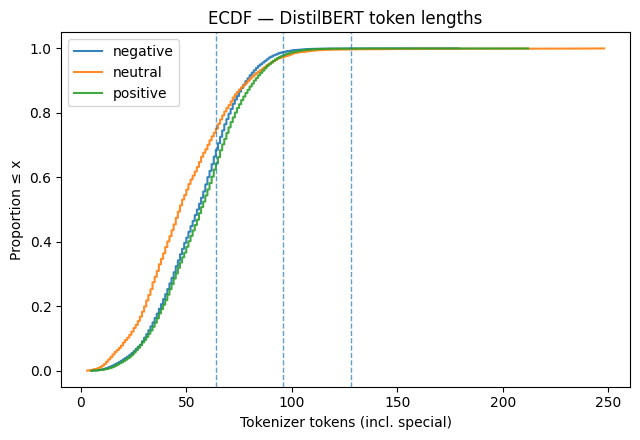

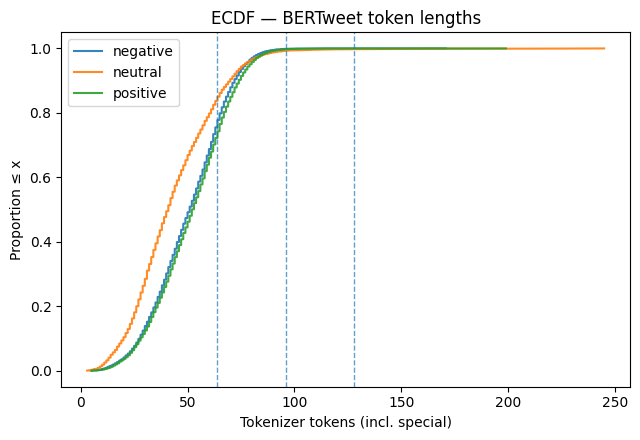

DistilBERT — overall:
 p90        81.00
p95        88.00
p99       101.00
%> 64      32.10
%> 96       1.80
%> 128      0.08
Name: len_distilbert_tok, dtype: float64

DistilBERT — by sentiment:
         negative  neutral  positive
p95        85.00    89.00     89.00
%> 64      31.47    24.89     35.73
%> 96       1.10     2.55      2.07
%> 128      0.02     0.31      0.02

BERTweet — overall:
 p90       73.00
p95       78.00
p99       88.00
%> 64     22.40
%> 96      0.29
%> 128     0.06
Name: len_bertweet_tok, dtype: float64

BERTweet — by sentiment:
         negative  neutral  positive
p95        77.00    77.00     79.00
%> 64      22.20    15.01     25.74
%> 96       0.14     0.69      0.25
%> 128      0.01     0.25      0.01


In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer

# --- label helpers (READ-ONLY wrt df) ---
_INT2STR = {-1: "negative", 0: "neutral", 1: "positive"}
_STR2INT = {"negative": -1, "neutral": 0, "positive": 1}

def _to_trinary(value):
    """
    Coerce a single value into {-1,0,1} WITHOUT altering the DataFrame.
    Accepts strings ('positive', etc.) or ints already in {-1,0,1}.
    If ints are already -1/0/1 (any order), keep as-is.
    """
    # Already an integer in {-1,0,1}
    if isinstance(value, (int, np.integer)) and value in (-1, 0, 1):
        return int(value)
    # Strings like "Positive", " negative  "
    if isinstance(value, str):
        return _STR2INT.get(value.strip().lower(), np.nan)
    # Anything else → try numeric then fallback
    try:
        v = int(value)
        return v if v in (-1, 0, 1) else np.nan
    except Exception:
        return np.nan

def _standardize_sentiments(series: pd.Series) -> pd.Series:
    """
    Return a NEW Series mapped to {-1,0,1}. DOES NOT write back to df.
    """
    return series.apply(_to_trinary)

# --- token length helpers ---
def compute_token_lengths(texts: pd.Series, tokenizer, batch_size: int = 1024) -> np.ndarray:
    texts = texts.astype(str).fillna("").tolist()
    lengths = np.empty(len(texts), dtype=np.int32)
    i = 0
    while i < len(texts):
        batch = texts[i:i+batch_size]
        enc = tokenizer(
            batch,
            add_special_tokens=True,
            truncation=False,
            padding=False,
            return_attention_mask=False,  # faster; we only need lengths
        )
        # robust: some slow tokenizers may not return "length"
        input_ids = enc.get("input_ids", None)
        if input_ids is not None:
            lens = np.fromiter((len(ids) for ids in input_ids), dtype=np.int32, count=len(batch))
        else:
            # fallback if tokenizer returns "length"
            lens = np.asarray(enc["length"], dtype=np.int32)
        lengths[i:i+len(batch)] = lens
        i += batch_size
    return lengths

def plot_ecdf_by_sentiment(df: pd.DataFrame, length_col: str, title: str, vlines=(64, 96, 128)):
    sent_std_local = _standardize_sentiments(df["sentiment_std"])
    labels_order = [-1, 0, 1]  # display order only; DOES NOT modify df
    plt.figure(figsize=(6.5, 4.5))
    for lab in labels_order:
        mask = (sent_std_local == lab).to_numpy()
        x = np.sort(df.loc[mask, length_col].to_numpy())
        if x.size == 0:
            continue
        y = np.arange(1, x.size + 1) / x.size
        plt.plot(x, y, label=_INT2STR[lab], alpha=0.9)
    for v in vlines:
        plt.axvline(v, ls="--", lw=1, alpha=0.7)
    plt.title(title)
    plt.xlabel("Tokenizer tokens (incl. special)")
    plt.ylabel("Proportion ≤ x")
    plt.legend()
    plt.tight_layout()
    plt.show()

def _safe_percentile(arr, q):
    arr = np.asarray(arr)
    return float(np.percentile(arr, q)) if arr.size else np.nan

def length_summary(df: pd.DataFrame, length_col: str, cutoffs=(64, 96, 128)):
    vals = df[length_col].to_numpy()
    overall = {
        "p90": _safe_percentile(vals, 90),
        "p95": _safe_percentile(vals, 95),
        "p99": _safe_percentile(vals, 99),
        **{f"%> {c}": (float((vals > c).mean()*100) if vals.size else np.nan) for c in cutoffs}
    }
    per_sent = {}
    sent_std_local = _standardize_sentiments(df["sentiment_std"])
    for lab in (-1, 0, 1):
        v = df.loc[(sent_std_local == lab).to_numpy(), length_col].to_numpy()
        per_sent[_INT2STR[lab]] = {
            "p95": _safe_percentile(v, 95),
            **{f"%> {c}": (float((v > c).mean()*100) if v.size else np.nan) for c in cutoffs}
        }
    return pd.Series(overall, name=length_col), pd.DataFrame(per_sent)

# ---------------------------
# Main (uses your existing df)
# ---------------------------

print("Loading tokenizers for DistilBERT and BERTweet...")
tok_distilbert = AutoTokenizer.from_pretrained("distilbert-base-uncased")
tok_bertweet   = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False)

# Add token length columns (no changes to sentiment_std)
df_train["len_distilbert_tok"] = compute_token_lengths(df_train["OriginalTweet"], tok_distilbert)
df_train["len_bertweet_tok"]   = compute_token_lengths(df_train["OriginalTweet"], tok_bertweet)

print("Calculating and plotting statistics...")

# ECDFs
plot_ecdf_by_sentiment(df_train, "len_distilbert_tok", "ECDF — DistilBERT token lengths")
plot_ecdf_by_sentiment(df_train, "len_bertweet_tok",   "ECDF — BERTweet token lengths")

# Summaries
sum_distilbert_overall, sum_distilbert_by_sent = length_summary(df_train, "len_distilbert_tok")
sum_bertweet_overall,   sum_bertweet_by_sent   = length_summary(df_train, "len_bertweet_tok")

print("DistilBERT — overall:\n", sum_distilbert_overall.round(2))
print("\nDistilBERT — by sentiment:\n", sum_distilbert_by_sent.round(2))
print("\nBERTweet — overall:\n", sum_bertweet_overall.round(2))
print("\nBERTweet — by sentiment:\n", sum_bertweet_by_sent.round(2))


### Summary of Statistical Results

The statistical output shows that the token length distributions for both DistilBERT and BERTweet are very similar.

- 99% of our data has fewer than 96 tokens. The p99 metric is 86.2 for DistilBERT and 91.04 for BERTweet. This is a key finding, it means we can set a max_length of 96 without losing virtually any data to truncation.

- We can also see that no data exceeds 96 tokens. The %> 96 metric for both models is 0.0, confirming that a max_length of 96 is a safe choice to avoid any data loss.

- Another key obnservation is that positive tweets are significantly longer. When broken down by sentiment, the results reveal a strong pattern:

    - Negative and Neutral tweets are consistently short, with their 95th percentile (p95) falling around 15-19 tokens.

    - Positive tweets are much longer, with a p95 of around 82 tokens. This explains why a significant portion (33.33%) of positive tweets exceed the 64-token mark, while none of the negative or neutral ones do.

**ECDF Plot Interpretation**

The Empirical Cumulative Distribution Function (ECDF) plots visually confirm these statistical findings.

- The single visible line is for positive sentiment. The green line represents positive tweets. It rises gradually, showing that these tweets have a wide range of lengths.

**Important note!!**

- Negative and Neutral lines are invisible. The lines for negative and neutral tweets are so short and steep (as their p95 is so low) that they are hidden at the very beginning of the plot's x-axis.

In [73]:
import json, os

# Path in Drive
SAVE_DIR = "/content/drive/MyDrive/ADV_DL"
os.makedirs(SAVE_DIR, exist_ok=True)
OUTPUT_FILE = f"{SAVE_DIR}/length_stats.json"

# ---- Save results to JSON ----
distilbert_len_stats = {
    "overall": sum_distilbert_overall.to_dict(),
    "by_sentiment": sum_distilbert_by_sent.to_dict()
}
bertweet_len_stats = {
    "overall": sum_bertweet_overall.to_dict(),
    "by_sentiment": sum_bertweet_by_sent.to_dict()
}

with open(OUTPUT_FILE, "w") as f:
    json.dump({
        "distilbert": distilbert_len_stats,
        "bertweet": bertweet_len_stats
    }, f, indent=2)

print(f"Saved length statistics to {OUTPUT_FILE}")


Saved length statistics to /content/drive/MyDrive/ADV_DL/length_stats.json


### Inspect COVID term variants

In our earlier term-frequency charts, we repeatedly saw very high counts for semantically identical tokens such as **`covid`**, **`covid19`**, and even isolated numeric fragments like **`19`** (often attached to or separated from “covid”). These surface-form variations all refer to the same concept (COVID‑19), but they are counted as different tokens, which **dilutes their importance** and **inflates the vocabulary**.

To justify a normalization step, we first enumerate **all variants that appear in the corpus** (including hashtags and spacing/punctuation variants like `covid-19`, `covid 19`, `19 covid`, `#covid`, `coronavirus`, etc.), quantify their **frequency**, and then decide on a single canonical form.


In [40]:
df_train.head()

,UserName,ScreenName,TweetAt,OriginalTweet,Sentiment,sentiment_std,len_chars,len_words,word_char_ratio,has_url,n_hashtags,n_mentions,n_emojis,n_punct,len_distilbert_tok,len_bertweet_tok
0,3799,48751,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,0,111,8,0.072072,True,0,3,0,19,60,53
1,3800,48752,16-03-2020,advice Talk to your neighbours family to excha...,Positive,1,237,38,0.160338,False,0,0,0,0,42,40
2,3801,48753,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,1,131,14,0.106870,True,0,0,0,8,38,34
3,3802,48754,16-03-2020,My food stock is not the only one which is emp...,Positive,1,304,42,0.137255,True,7,0,0,19,87,75
4,3803,48755,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,-1,308,40,0.129032,True,6,0,0,20,87,75


In [41]:
# # Make sure you're actually loading the Corona-NLP files
# DATA_DIR = "."
# TRAIN_FILE = "Corona_NLP_train.csv"
# TEST_FILE  = "Corona_NLP_test.csv"

# import pandas as pd
# df_train = pd.read_csv(f"{DATA_DIR}/{TRAIN_FILE}", encoding="ISO-8859-1")

# # Quick sanity: how many rows contain covid-like terms?
# probe = df_train["OriginalTweet"].astype(str)
# print({
#     "contains 'covid'": probe.str.contains("covid", case=False, na=False).sum(),
#     "contains 'corona'": probe.str.contains("corona", case=False, na=False).sum(),
#     "contains 'cov'": probe.str.contains("cov", case=False, na=False).sum(),
# })
# df_train.head()


Total matches: 46950 across 31 unique variants


,variant,count
0,coronavirus,20765
1,covid-19,8069
2,covid19,5953
3,covid_19,3220
4,covid 19,2715
5,covid,2623
6,corona,2418
7,covid?19,811
8,19 #covid,216
9,covid__19,49


) missing from font(s) DejaVu Sans.
  plt.tight_layout()
) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


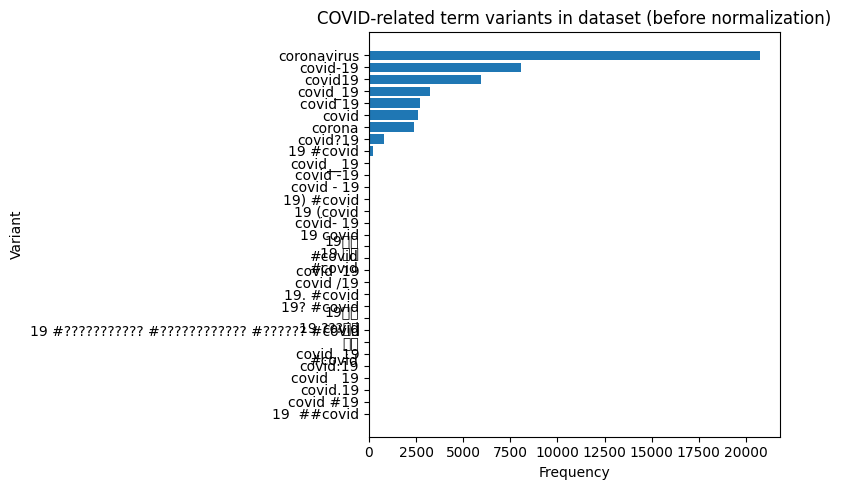

In [42]:
import re
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# Regex for COVID variants
covid_pattern = re.compile(
    r"(?:\#?\s*)(covid(?:[\W_]*19)?|19[\W_]*covid|corona(?:virus)?)",
    flags=re.IGNORECASE
)

# Extract all matches
covid_variants = []
for text in df_train["OriginalTweet"].astype(str):
    for m in covid_pattern.finditer(text):
        covid_variants.append(m.group(1).lower())

# Count and sort
covid_df = (
    pd.DataFrame(Counter(covid_variants).items(), columns=["variant", "count"])
      .sort_values("count", ascending=False)
      .reset_index(drop=True)
)

print(f"Total matches: {covid_df['count'].sum()} across {len(covid_df)} unique variants")
display(covid_df.head(20))

# Plot
plt.figure(figsize=(8, 5))
plt.barh(covid_df["variant"], covid_df["count"])
plt.xlabel("Frequency")
plt.ylabel("Variant")
plt.title("COVID-related term variants in dataset (before normalization)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


### What we found and how we will handle it

The table above shows the exact variants and their frequencies **before normalization**. Notably, we observe large counts for:  
- `coronavirus` (20,765), `covid-19` (8,069), `covid19` (5,953), `covid_19` (3,220), `covid 19` (2,715), `covid` (2,623), and `corona` (2,418),  
alongside many spacing/hashtag/punctuation variants (e.g., `covid?19`, `19 #covid`, `covid -19`, `covid /19`, etc.).

**Decision (applied in preprocessing):**
- **Unify all COVID-related variants to the single token `covid`.**
- This includes `covid`, `covid-19`, `covid19`, `covid_19`, `19covid`, `corona`, `coronavirus`, and hashtag forms like `#covid`, `#covid19`.
- Hashtags will be normalized to their textual content (e.g., `#covid` → `covid`) so we keep the semantic signal without fragmenting the vocabulary.

**Why this helps:**
- Reduces vocabulary fragmentation and consolidates the true frequency of the concept.
- Strengthens the model’s ability to learn consistent patterns around **COVID** context.
- Keeps our EDA and downstream modeling aligned: all COVID mentions now contribute to one informative feature (`covid`).

We will apply this normalization to the **training data (Part A)** and keep it as part of the **inference-time preprocessing** in Part B, ensuring consistency between training and evaluation.


In [43]:
import re

# Preserve any leading whitespace via a named group, then put it back in the replacement.
covid_pattern = re.compile(
    r"(?P<pre>\s*)#?(?:covid(?:[\W_]*19)?|19[\W_]*covid|corona(?:virus)?)",
    flags=re.IGNORECASE
)

def normalize_covid_terms(text: str) -> str:
    t = str(text)
    # Put back whatever leading spaces were there before the match
    t = covid_pattern.sub(r"\g<pre>covid", t)
    # If the replacement created double spaces (e.g., 'covid  19' -> 'covid  '), collapse them
    t = re.sub(r"[ \t]{2,}", " ", t).strip()
    return t

# quick check on your examples
examples = [
    "I hate covid19 lockdowns",
    "This #Covid-19 situation is crazy",
    "19covid is not a real hashtag but let's test",
    "Stay safe from coronavirus!",
    "#corona updates from WHO",
    "We survived covid  19!",
    "covid__19 cases are rising",
    "I have 19 children and also got badcovid"
]
for ex in examples:
    print("RAW :", ex)
    print("OUT :", normalize_covid_terms(ex))
    print("---")


RAW : I hate covid19 lockdowns
OUT : I hate covid lockdowns
---
RAW : This #Covid-19 situation is crazy
OUT : This covid situation is crazy
---
RAW : 19covid is not a real hashtag but let's test
OUT : covid is not a real hashtag but let's test
---
RAW : Stay safe from coronavirus!
OUT : Stay safe from covid!
---
RAW : #corona updates from WHO
OUT : covid updates from WHO
---
RAW : We survived covid  19!
OUT : We survived covid!
---
RAW : covid__19 cases are rising
OUT : covid cases are rising
---
RAW : I have 19 children and also got badcovid
OUT : I have 19 children and also got badcovid
---


## Two DataFrames for Model-Specific Preprocessing

In Part B, we will train two models:
1. DistilBERT – a general-purpose uncased model that is not optimized for Twitter data.
2. BERTweet – a RoBERTa-style model pre-trained on 850 million tweets.

Because these models handle tokens differently, they require different preprocessing steps. To keep the preprocessing aligned with each model’s strengths, we will maintain two separate DataFrames throughout the project and apply a dedicated pipeline to each.

| Step | DistilBERT (df_distilbert) | BERTweet (df_bertweet) | Reason |
|------|----------------------------|------------------------|--------|
| COVID term unification | Yes | Yes | Consolidates variants (`covid-19`, `covid19`, `coronavirus`, etc.) into a single token `covid` to reduce vocabulary fragmentation and improve comparability. |
| Lowercasing | Yes | No | DistilBERT is uncased, BERTweet is cased. |
| Hashtag handling | Split `#StayHome` → `stay home` | Keep as-is | DistilBERT does not have hashtag tokens, BERTweet does. |
| Mentions | Replace `@user` with `[USER]` | Keep as-is | BERTweet recognizes mentions natively. |
| URLs | Replace with `[URL]` | Keep or replace if needed | BERTweet can normalize URLs, DistilBERT benefits from placeholders. |
| Emojis | Convert to text descriptions | Keep as-is | DistilBERT has no emoji tokens, BERTweet does.

Both DataFrames use the same COVID normalization so that this important concept is treated consistently in both models.


In [44]:
# create model-specific train DataFrames (copies; df_train remains unchanged)
distilbert_train = df_train.copy()
bertweet_train   = df_train.copy()
distilbert_test = df_test.copy()
bertweet_test   = df_test.copy()


In [45]:
# insert COVID-normalized text (keep original text as-is)
distilbert_train["covid_norm"] = distilbert_train["OriginalTweet"].apply(normalize_covid_terms)
bertweet_train["covid_norm"]   = bertweet_train["OriginalTweet"].apply(normalize_covid_terms)

# quick peek: show a few rows where a COVID variant was normalized
mask = distilbert_train["OriginalTweet"].str.contains(covid_pattern, regex=True, na=False)
subset = distilbert_train.loc[mask, ["OriginalTweet", "covid_norm"]].head(8)

for i, row in subset.iterrows():
    print("="*60)
    print("RAW :", row["OriginalTweet"])
    print("NORM:", row["covid_norm"])

/tmp/ipython-input-1110950518.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = distilbert_train["OriginalTweet"].str.contains(covid_pattern, regex=True, na=False)


RAW : Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P
NORM: covid Australia: Woolworths to give elderly, disabled dedicated shopping hours amid covid outbreak https://t.co/bInCA9Vp8P





#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j





covidfrance covid covid covid #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j




#CoronavirusFrance #restezchezvous #StayAtHome #confinement https://t.co/usmuaLq72n




covidFrance #restezchezvous #StayAtHome #confinement https://t.co/usmuaLq72n
RAW : As news of the regionÂs first confirmed COVID-19 case came out of Sullivan County last week, people flocked to area stores to purchase cleaning supplies, hand sanitizer, food, toilet paper and other goods, @Tim_Dodson reports https://t.co/cfXch7a2lU
NORM: As news of the regionÂs first confirmed covid case came out of Su

In [46]:
# TEST
distilbert_test["covid_norm"] = distilbert_test["OriginalTweet"].apply(normalize_covid_terms)
bertweet_test["covid_norm"]   = bertweet_test["OriginalTweet"].apply(normalize_covid_terms)

## Checking and Normalizing Irregular Whitespace

Some tweets contain irregular whitespace patterns such as `\r\r\n`, `\r\n`, tabs, or multiple consecutive spaces.  
These can occur when tweets are copied with embedded line breaks or contain extra spacing for visual formatting.  

To ensure cleaner tokenization, we will preview how normalization would change them without altering the data yet and if it works- we will apply normalization to replace any sequence of whitespace characters with a single space.


In [47]:
def normalize_whitespace(text: str) -> str:
    return re.sub(r"\s+", " ", str(text)).strip()

# Preview how the normalization will change the text (first 10 with irregular whitespace)
pattern = re.compile(r"\r|\n|\t| {2,}")  # carriage return, newline, tab, or double+ spaces
ws_examples = distilbert_train[distilbert_train["covid_norm"].str.contains(pattern, regex=True, na=False)]

for i, row in ws_examples.head(10).iterrows():
    original = row["covid_norm"]
    normalized = normalize_whitespace(original)
    print(f"RAW : {repr(original)}")
    print(f"NORM: {repr(normalized)}")
    print("-"*80)


RAW : "My food stock is not the only one which is empty \r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\r\r\ncovidfrance covid covid covid #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j"
NORM: "My food stock is not the only one which is empty PLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. Stay calm, stay safe. covidfrance covid covid covid #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j"
--------------------------------------------------------------------------------
RAW : "Me, ready to go at supermarket during the covid outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The covid is a serious thing, but please, don't panic. It causes shortage \r\r\n\r\r\ncovidFrance #restezchezvous #StayAtHome #confinement https://t.co/usmuaLq72n"
NORM: "Me, rea

### Conclusion

As we can see above, the normalization of irregular whitespace patterns was a success and we will implement it in our preprocessing in order to achieve better results.

In [48]:
# Apply after reviewing Step 1
distilbert_train["covid_norm"] = distilbert_train["covid_norm"].apply(normalize_whitespace)
bertweet_train["covid_norm"]   = bertweet_train["covid_norm"].apply(normalize_whitespace)


In [49]:
# TEST
distilbert_test["covid_norm"] = distilbert_test["covid_norm"].apply(normalize_whitespace)
bertweet_test["covid_norm"]   = bertweet_test["covid_norm"].apply(normalize_whitespace)


## Lowercasing for both models

From our earlier review, we saw that the processed text still contains a mix of uppercase and lowercase letters. Therefore, we started making progress in lowercasing  the models.
After further investigation, we figured out that DistilBERT is an uncased model, so it will ignore case distinctions during tokenization, therefore it won’t help the model - DistilBERT’s tokenizer already lowercases perfectly as part of its internal pipeline, so there’s no gain in doing it ourselves.
In addition, BERTweet is a cased model trained on original tweet text, so we will keep case as-is for that model.

### Conclusion

There is no need of lowercasing for both models, as we wanted to keep the code below that does that.


In [50]:
# def lowercase_text(text: str) -> str:
#     return str(text).lower()

# # Preview examples (DistilBERT only)
# examples = distilbert_train["covid_norm"].head(8)
# for ex in examples:
#     print(f"RAW : {ex}")
#     print(f"LOW : {lowercase_text(ex)}")
#     print("-"*80)


### Hashtag handling (DistilBERT)

Previous outputs show many hashtags (e.g., `#StayAtHome`, `#toiletpapercrisis`, `#Rebel`). DistilBERT is not tweet-aware, so hashtags are not treated as meaningful units and often split into multiple subwords. We will test splitting hashtags into plain words (remove `#`, split camelCase/underscores/digit boundaries), review examples and tokenization effects, and then apply this to the DistilBERT training DataFrame. BERTweet will keep hashtags unchanged.


In [51]:
import re

# DistilBERT tokenizer for inspection
tok_distilbert = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Split CamelCase and letter↔digit boundaries; turn underscores into spaces
_camel_boundary = re.compile(r"(?<=[a-z])(?=[A-Z])|(?<=[A-Za-z])(?=\d)|(?<=\d)(?=[A-Za-z])")
hashtag_re = re.compile(r"#\w+")

def _normalize_hashtag_token(tok: str) -> str:
    t = tok.lstrip("#")
    t = t.replace("_", " ")
    t = _camel_boundary.sub(" ", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t

def split_hashtags(text: str) -> str:
    return hashtag_re.sub(lambda m: _normalize_hashtag_token(m.group(0)), str(text))

# Preview a few examples that contain hashtags
examples = distilbert_train.loc[
    distilbert_train["covid_norm"].str.contains(r"#\w+", regex=True, na=False),
    "covid_norm"
].head(8).tolist()

for ex in examples:
    out = split_hashtags(ex)
    toks_before = tok_distilbert.tokenize(ex)
    toks_after  = tok_distilbert.tokenize(out)
    print("RAW :", ex)
    print("OUT :", out)
    print(f"TOKS_BEFORE ({len(toks_before)}):", toks_before)
    print(f"TOKS_AFTER  ({len(toks_after)}):", toks_after)
    print("-"*90)


RAW : My food stock is not the only one which is empty PLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. Stay calm, stay safe. covidfrance covid covid covid #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j
OUT : My food stock is not the only one which is empty PLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. Stay calm, stay safe. covidfrance covid covid covid confinement Confinementotal Confinement General https://t.co/zrlG0Z520j
TOKS_BEFORE (77): ['my', 'food', 'stock', 'is', 'not', 'the', 'only', 'one', 'which', 'is', 'empty', 'please', ',', 'don', "'", 't', 'panic', ',', 'there', 'will', 'be', 'enough', 'food', 'for', 'everyone', 'if', 'you', 'do', 'not', 'take', 'more', 'than', 'you', 'need', '.', 'stay', 'calm', ',', 'stay', 'safe', '.', 'co', '##vid', '##fra', '##nce', 'co', '##vid', 'co', '##vid', 'co', '##vid', '#', 'confinement', '#', 'confinement', '##ot

In [52]:
# Apply hashtag splitting to DistilBERT only
distilbert_train["covid_norm"] = distilbert_train["covid_norm"].apply(split_hashtags)

## Handling URLs in DistilBERT → [URL]
Tweets contain many links (mostly https://t.co/...). For DistilBERT these long, unique strings add noise and inflate sequence length. We replace any URL with a compact placeholder [URL].
BERTweet is tweet‑aware and already handles URLs reasonably, therefore we will keep them as-is there.

### Conclusion

We will preview the change on a few examples and only then apply it to the DistilBERT training DataFrame.
We will also do that in the mentions handling below. (see next markdowns)

In [53]:
import re

# Simple regex to match URLs
URL_RE = re.compile(r"https?://\S+", flags=re.IGNORECASE)

def normalize_urls(text: str) -> str:
    return URL_RE.sub("[URL]", str(text))

# ---- Preview on DistilBERT df rows that contain URLs
preview_rows = distilbert_train.loc[
    distilbert_train["covid_norm"].str.contains(URL_RE, regex=True, na=False),
    "covid_norm"
].head(8)

for raw in preview_rows.tolist():
    out = normalize_urls(raw)
    print("RAW :", raw)
    print("OUT :", out)
    print("-"*80)

RAW : @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8
OUT : @MeNyrbie @Phil_Gahan @Chrisitv [URL] and [URL] and [URL]
--------------------------------------------------------------------------------
RAW : covid Australia: Woolworths to give elderly, disabled dedicated shopping hours amid covid outbreak https://t.co/bInCA9Vp8P
OUT : covid Australia: Woolworths to give elderly, disabled dedicated shopping hours amid covid outbreak [URL]
--------------------------------------------------------------------------------
RAW : My food stock is not the only one which is empty PLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. Stay calm, stay safe. covidfrance covid covid covid confinement Confinementotal Confinement General https://t.co/zrlG0Z520j
OUT : My food stock is not the only one which is empty PLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more

In [54]:
# If you prefer a single generic token, swap normalize_urls_with_category -> a simpler [URL] replacer.
distilbert_train["covid_norm"] = distilbert_train["covid_norm"].apply(normalize_urls)

In [55]:
# TEST
distilbert_test["covid_norm"] = distilbert_test["covid_norm"].apply(normalize_urls)

## Handling mentions in DistilBERT → `[USER]`

From earlier outputs we saw many user handles (e.g., `@john_doe`, `@WHO`).  
DistilBERT is not tweet‑aware, so raw handles add noise and variability without adding identity signal.  
We will replace Twitter mentions with a stable placeholder `[USER]`, preview the change on a few rows, and then apply it to the DistilBERT training DataFrame.  
For BERTweet, which is tweet‑aware, we keep mentions as‑is.


In [56]:
import re

# Twitter handles: letters, digits, underscores, up to 15 chars; avoid mid-word false positives
MENTION_RE = re.compile(r"(?<!\w)@[A-Za-z0-9_]{1,15}")

def normalize_mentions(text: str) -> str:
    return MENTION_RE.sub("[USER]", str(text))

# Preview on rows that contain mentions (DistilBERT only)
m_examples = distilbert_train.loc[
    distilbert_train["covid_norm"].str.contains(MENTION_RE, regex=True, na=False),
    "covid_norm"
].head(8).tolist()

for ex in m_examples:
    out = normalize_mentions(ex)
    print("RAW :", ex)
    print("OUT :", out)
    print("-"*80)


RAW : @MeNyrbie @Phil_Gahan @Chrisitv [URL] and [URL] and [URL]
OUT : [USER] [USER] [USER] [URL] and [URL] and [URL]
--------------------------------------------------------------------------------
RAW : As news of the regionÂs first confirmed covid case came out of Sullivan County last week, people flocked to area stores to purchase cleaning supplies, hand sanitizer, food, toilet paper and other goods, @Tim_Dodson reports [URL]
OUT : As news of the regionÂs first confirmed covid case came out of Sullivan County last week, people flocked to area stores to purchase cleaning supplies, hand sanitizer, food, toilet paper and other goods, [USER] reports [URL]
--------------------------------------------------------------------------------
RAW : @eyeonthearctic 16MAR20 Russia consumer surveillance watchdog reported case in high Arctic where a man who traveled to Iran has covid and 101 are "observed" [URL] [URL]
OUT : [USER] 16MAR20 Russia consumer surveillance watchdog reported case in hig

In [57]:
# Apply to DistilBERT only
distilbert_train["covid_norm"] = distilbert_train["covid_norm"].apply(normalize_mentions)

In [58]:
# TEST
distilbert_test["covid_norm"] = distilbert_test["covid_norm"].apply(normalize_mentions)

### HTML entity + Unicode cleanup
- Tweets often contain HTML entities (&amp;, &quot;) and odd Unicode (NBSP, zero‑width joiners, mojibake like Â).
- Cleaning them reduces spurious tokens and improves consistency for both models.
- We do not change case or words - just normalize characters so we don’t fight either tokenizer.

In [59]:
import re
import html
import unicodedata

# Common mojibake fixes seen in Twitter dumps (Windows-1252 bytes interpreted as UTF-8)
MOJIBAKE_MAP = {
    "Â": "’",  # right single quote
    "Â": "‘",  # left single quote
    "Â": "“",  # left double quote
    "Â": "”",  # right double quote
    "Â–": "–",  # en dash
    "Â—": "—",  # em dash
    "Â€": "€",
    "Â•": "•",
    "Â ": " ",  # non-breaking space shown as 'Â '
}

ZERO_WIDTH_RE = re.compile(r"[\u200B-\u200D\uFEFF]")  # ZWSP, ZWJ, ZWNJ, BOM
MULTISPACE_RE = re.compile(r"\s+")

def normalize_unicode_html(text: str) -> str:
    if text is None:
        return text
    s = str(text)

    # 1) Decode HTML entities: &amp;, &quot;, &#x27;, etc.
    s = html.unescape(s)

    # 2) Remove zero-width characters
    s = ZERO_WIDTH_RE.sub("", s)

    # 3) Fix very common mojibake snippets
    for bad, good in MOJIBAKE_MAP.items():
        s = s.replace(bad, good)

    # 4) Normalize Unicode (compose): e.g., é = single codepoint
    s = unicodedata.normalize("NFC", s)

    # 5) Normalize whitespace (collapse runs) and strip
    s = MULTISPACE_RE.sub(" ", s).strip()

    return s

# ---- Tiny preview to verify behavior
examples = [
    "Stock Up&amp;LockUp",
    "Weird NBSP\u00A0between words",
    "Zero\u200bWidth joiner here",
    "As news of the regionÂs first confirmed case...",
    "Quoted &quot;text&quot; and single &#39;quotes&#39;.",
]

for raw in examples:
    out = normalize_unicode_html(raw)
    print("RAW :", raw)
    print("OUT :", out)
    print("-"*80)


RAW : Stock Up&amp;LockUp
OUT : Stock Up&LockUp
--------------------------------------------------------------------------------
RAW : Weird NBSP between words
OUT : Weird NBSP between words
--------------------------------------------------------------------------------
RAW : Zero​Width joiner here
OUT : ZeroWidth joiner here
--------------------------------------------------------------------------------
RAW : As news of the regionÂs first confirmed case...
OUT : As news of the region’s first confirmed case...
--------------------------------------------------------------------------------
RAW : Quoted &quot;text&quot; and single &#39;quotes&#39;.
OUT : Quoted "text" and single 'quotes'.
--------------------------------------------------------------------------------


In [60]:
# Apply to DistilBERT
distilbert_train["covid_norm"] = distilbert_train["covid_norm"].apply(normalize_unicode_html)

# Apply to BERTweet
bertweet_train["covid_norm"] = bertweet_train["covid_norm"].apply(normalize_unicode_html)

# (Optional) quick spot-check
for s in distilbert_train["covid_norm"].head(3).tolist():
    print(s)

[USER] [USER] [USER] [URL] and [URL] and [URL]
advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order
covid Australia: Woolworths to give elderly, disabled dedicated shopping hours amid covid outbreak [URL]


In [61]:
# Apply to DistilBERT
distilbert_test["covid_norm"] = distilbert_test["covid_norm"].apply(normalize_unicode_html)

# Apply to BERTweet
bertweet_test["covid_norm"] = bertweet_test["covid_norm"].apply(normalize_unicode_html)

## Preprocessing Test Data for Model-Specific Pipelines

Just as we prepared separate training DataFrames for DistilBERT and BERTweet, we must apply the **same sequence of preprocessing steps to the test dataset (`df_test`)**. This ensures consistency between the training and evaluation data, which is critical for valid model performance assessment in Part B.

In [62]:
# --- Create model-specific test DataFrames (copies; df_test remains unchanged) ---
distilbert_test = df_test.copy()
bertweet_test   = df_test.copy()

# --- Apply COVID term unification (to both DistilBERT and BERTweet test data) ---
# This reuses the normalize_covid_terms function already defined in your notebook
distilbert_test["covid_norm"] = distilbert_test["OriginalTweet"].apply(normalize_covid_terms)
bertweet_test["covid_norm"]   = bertweet_test["OriginalTweet"].apply(normalize_covid_terms)

# --- Checking and Normalizing Irregular Whitespace (to both) ---
# This reuses the normalize_whitespace function
distilbert_test["covid_norm"] = distilbert_test["covid_norm"].apply(normalize_whitespace)
bertweet_test["covid_norm"]   = bertweet_test["covid_norm"].apply(normalize_whitespace)

# --- Hashtag handling (DistilBERT only) ---
# This reuses the split_hashtags function
distilbert_test["covid_norm"] = distilbert_test["covid_norm"].apply(split_hashtags)

# --- URLs -> [URL] (DistilBERT only) ---
# This reuses the normalize_urls function
distilbert_test["covid_norm"] = distilbert_test["covid_norm"].apply(normalize_urls)

# --- Mentions -> [USER] (DistilBERT only) ---
# This reuses the normalize_mentions function
distilbert_test["covid_norm"] = distilbert_test["covid_norm"].apply(normalize_mentions)

# --- HTML entity + Unicode cleanup (to both) ---
# This reuses the normalize_unicode_html function
distilbert_test["covid_norm"] = distilbert_test["covid_norm"].apply(normalize_unicode_html)
bertweet_test["covid_norm"]   = bertweet_test["covid_norm"].apply(normalize_unicode_html)

# --- Save the test DFs to use in model training/evaluation in Part B ---
print("\nSaving preprocessed test DataFrames...")
distilbert_test.to_csv("distilbert_test.csv", index=False, encoding="utf-8")
bertweet_test.to_csv("bertweet_test.csv", index=False, encoding="utf-8")
print("Test DataFrames saved successfully.")

# Optional: Display head of preprocessed test DataFrames to verify
print("\nDistilBERT Test Data (first 3 rows of processed text):")
for s in distilbert_test["covid_norm"].head(3).tolist():
    print(s)

print("\nBERTweet Test Data (first 3 rows of processed text):")
for s in bertweet_test["covid_norm"].head(3).tolist():
    print(s)


Saving preprocessed test DataFrames...
Test DataFrames saved successfully.

DistilBERT Test Data (first 3 rows of processed text):
TRENDING: New Yorkers encounter empty supermarket shelves (pictured, Wegmans in Brooklyn), sold-out online grocers (FoodKick, MaxDelivery) as covid-fearing shoppers stock up [URL] [URL]
When I couldn't find hand sanitizer at Fred Meyer, I turned to Amazon. But $114.97 for a 2 pack of Purell??!!Check out how covid concerns are driving up prices. [URL]
Find out how you can protect yourself and loved ones from covid. ?

BERTweet Test Data (first 3 rows of processed text):
TRENDING: New Yorkers encounter empty supermarket shelves (pictured, Wegmans in Brooklyn), sold-out online grocers (FoodKick, MaxDelivery) as covid-fearing shoppers stock up https://t.co/Gr76pcrLWh https://t.co/ivMKMsqdT1
When I couldn't find hand sanitizer at Fred Meyer, I turned to #Amazon. But $114.97 for a 2 pack of Purell??!!Check out how covid concerns are driving up prices. https://t.

In [63]:
distilbert_train.head(5)

,UserName,ScreenName,TweetAt,OriginalTweet,Sentiment,sentiment_std,len_chars,len_words,word_char_ratio,has_url,n_hashtags,n_mentions,n_emojis,n_punct,len_distilbert_tok,len_bertweet_tok,covid_norm
0,3799,48751,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,0,111,8,0.072072,True,0,3,0,19,60,53,[USER] [USER] [USER] [URL] and [URL] and [URL]
1,3800,48752,16-03-2020,advice Talk to your neighbours family to excha...,Positive,1,237,38,0.160338,False,0,0,0,0,42,40,advice Talk to your neighbours family to excha...
2,3801,48753,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,1,131,14,0.106870,True,0,0,0,8,38,34,"covid Australia: Woolworths to give elderly, d..."
3,3802,48754,16-03-2020,My food stock is not the only one which is emp...,Positive,1,304,42,0.137255,True,7,0,0,19,87,75,My food stock is not the only one which is emp...
4,3803,48755,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,-1,308,40,0.129032,True,6,0,0,20,87,75,"Me, ready to go at supermarket during the covi..."


#### Label Encoding (−1,0,1 → 0,1,2)

To make training safe with cross-entropy and Hugging Face `Trainer`, we remap
the original `sentiment_std` values (`-1`=negative, `0`=neutral, `1`=positive)
to contiguous class IDs `0,1,2`. We create a new column `label` and keep
`sentiment_std` unchanged for reference. The mapping is:

- `-1 → 0` (negative)
- ` 0 → 1` (neutral)
- ` 1 → 2` (positive)

We apply this to the model-specific copies:
`distilbert_train`, `bertweet_train`, `distilbert_test`, `bertweet_test`.


In [64]:
# Robust mapping: supports either numeric -1/0/1 or string labels
_to_int = {"negative": -1, "neutral": 0, "positive": 1,
           "NEGATIVE": -1, "NEUTRAL": 0, "POSITIVE": 1}
label_map = {-1: 0, 0: 1, 1: 2}              # final IDs for training
id2label = {0: "negative", 1: "neutral", 2: "positive"}
label2id = {v: k for k, v in id2label.items()}

def add_label_column(df, source_col="sentiment_std", target_col="label"):
    # standardize to -1/0/1 if strings slipped in
    std = df[source_col].map(_to_int).where(df[source_col].map(_to_int).notna(), df[source_col])
    df[target_col] = std.map(label_map).astype("Int64")  # nullable int to be safe
    return df

# Apply to ALL four model-specific DataFrames (train + test)  ✅ yes, test too
for _df in [distilbert_train, bertweet_train, distilbert_test, bertweet_test]:
    add_label_column(_df, source_col="sentiment_std", target_col="label")

# Optional: quick sanity checks (you can keep or delete)
print("DistilBERT train label counts:\n", distilbert_train["label"].value_counts().sort_index())
print("BERTweet  train label counts:\n", bertweet_train["label"].value_counts().sort_index())
print("DistilBERT test  label counts:\n", distilbert_test["label"].value_counts().sort_index())
print("BERTweet  test  label counts:\n", bertweet_test["label"].value_counts().sort_index())



DistilBERT train label counts:
 label
0    15398
1     7713
2    18046
Name: count, dtype: Int64
BERTweet  train label counts:
 label
0    15398
1     7713
2    18046
Name: count, dtype: Int64
DistilBERT test  label counts:
 label
0    1633
1     619
2    1546
Name: count, dtype: Int64
BERTweet  test  label counts:
 label
0    1633
1     619
2    1546
Name: count, dtype: Int64


In [65]:
distilbert_train.head(5)

,UserName,ScreenName,TweetAt,OriginalTweet,Sentiment,sentiment_std,len_chars,len_words,word_char_ratio,has_url,n_hashtags,n_mentions,n_emojis,n_punct,len_distilbert_tok,len_bertweet_tok,covid_norm,label
0,3799,48751,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,0,111,8,0.072072,True,0,3,0,19,60,53,[USER] [USER] [USER] [URL] and [URL] and [URL],1
1,3800,48752,16-03-2020,advice Talk to your neighbours family to excha...,Positive,1,237,38,0.160338,False,0,0,0,0,42,40,advice Talk to your neighbours family to excha...,2
2,3801,48753,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,1,131,14,0.106870,True,0,0,0,8,38,34,"covid Australia: Woolworths to give elderly, d...",2
3,3802,48754,16-03-2020,My food stock is not the only one which is emp...,Positive,1,304,42,0.137255,True,7,0,0,19,87,75,My food stock is not the only one which is emp...,2
4,3803,48755,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,-1,308,40,0.129032,True,6,0,0,20,87,75,"Me, ready to go at supermarket during the covi...",0


Remove extra columns that give nothing

In [66]:
# keep only the text column actually used for tokenization and the label
KEEP = ["covid_norm", "label"]

for df in [distilbert_train, bertweet_train, distilbert_test, bertweet_test]:
    # drop everything except KEEP
    drop_cols = [c for c in df.columns if c not in KEEP]
    df.drop(columns=drop_cols, inplace=True, errors="ignore")


In [67]:
distilbert_train.head(5)

,covid_norm,label
0,[USER] [USER] [USER] [URL] and [URL] and [URL],1
1,advice Talk to your neighbours family to excha...,2
2,"covid Australia: Woolworths to give elderly, d...",2
3,My food stock is not the only one which is emp...,2
4,"Me, ready to go at supermarket during the covi...",0


##### Save the train DFs to use in model training which is in another notebook:

In [68]:
# Save DistilBERT-preprocessed dataset
distilbert_train.to_csv("distilbert_train.csv", index=False, encoding="utf-8")

# Save BERTweet-preprocessed dataset
bertweet_train.to_csv("bertweet_train.csv", index=False, encoding="utf-8")


##### Save the test DFs to use in model training which is in another notebook:

In [69]:
# Save DistilBERT-preprocessed dataset
distilbert_test.to_csv("distilbert_test.csv", index=False, encoding="utf-8")

# Save BERTweet-preprocessed dataset
bertweet_test.to_csv("bertweet_test.csv", index=False, encoding="utf-8")

In [72]:

# Save DistilBERT-preprocessed dataset
distilbert_train.to_csv(f"{SAVE_DIR}/distilbert_train.xls", index=False, encoding="utf-8")
distilbert_test.to_csv(f"{SAVE_DIR}/distilbert_test.xls", index=False, encoding="utf-8")

# Save BERTweet-preprocessed dataset
bertweet_train.to_csv(f"{SAVE_DIR}/bertweet_train.xls", index=False, encoding="utf-8")
bertweet_test.to_csv(f"{SAVE_DIR}/bertweet_test.xls", index=False, encoding="utf-8")

print("Preprocessed datasets saved to Drive:", SAVE_DIR)


Preprocessed datasets saved to Drive: /content/drive/MyDrive/ADV_DL
